In [ ]:
import os
import time
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

import torch
torch.backends.cudnn.benchmark = False
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils import data

torch.cuda.empty_cache() 
torch.backends.cudnn.benchmark=True

class IteratorTimer():
    def __init__(self, iterable):
        self.iterable = iterable
        self.iterator = self.iterable.__iter__()

    def __iter__(self):
        return self

    def __len__(self):
        return len(self.iterable)

    def __next__(self):
        start = time.time()
        n = self.iterator.next()
        self.last_duration = (time.time() - start)
        return n

    next = __next__

def shuffle_in_unison(x_data, y_data, seed=195735):
    '''
    This method shuffles the data of the Data Set axis of the test and training data.
    It is inspired by http://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
    '''
    np.random.seed(seed)
    shuffled_x = np.empty(x_data.shape, dtype=x_data.dtype)
    shuffled_y = np.empty(y_data.shape, dtype=y_data.dtype)
    permutation = np.random.permutation(x_data.shape[2])
    for old_index, new_index in enumerate(permutation):
        shuffled_x[::,::,new_index,::,::] = x_data[::,::,old_index,::,::]
        shuffled_y[::,::,new_index] = y_data[::,::,old_index]
    return shuffled_x, shuffled_y

def split_data(x_data, y_data, validation_fraction=0.2):
    """
    Splits the data into training and validation data
    according to the fraction that was specified. The samples are shuffled and then selected.
    The data is equally splitted along classes and signal to noise ratios.
    The new data array, validation array and the according label arrays are returned.
    """
    # Shuffle data
    x_data, y_data = shuffle_in_unison(x_data, y_data)
    # Split data
    nb_sets = x_data.shape[2]
    nb_cutted = int(np.floor(nb_sets * validation_fraction))
    x_test = x_data[::,::,-1:(-nb_cutted-1):-1,::,::]
    y_test = y_data[::,::,-1:(-nb_cutted-1):-1]
    x_data = np.delete(x_data, np.s_[-1:(-nb_cutted-1):-1], axis=2)
    y_data = np.delete(y_data, np.s_[-1:(-nb_cutted-1):-1], axis=2)
    return x_data, y_data, x_test, y_test

def load_data(storage_folder, which_kind):
    """
    Unpickle the data stored in the folder. The name of the measurement data
    inside the folder is considered as 'data_arrays_$which_kind-data-' + $standards and the
    label data is considered as 'labels-data-' + $standards.
    The measurement data and the labels for each standard 
    are returned in a list.
    Standard must be a list of Strings. The data is loaded in the order of the
    standards.
    """
    x_data = None
    y_data = None
    data_file = None
    # decide which data to load
    if which_kind == 'iq':
        data_file = 'data_iq.p'
    elif which_kind == 'fft':
        data_file = 'data_fft.p'
    elif which_kind == 'amplitude phase':
        data_file = 'data_amplitude_phase.p'
    elif which_kind == 'fft amplitude phase':
        data_file = 'data_fft_amplitude_phase.p'
    else:
        raise ValueError('Parameter which_kind must be "iq" for IQ-data or "fft" for FFT-data.')
    # load input data (x)
    data_path = os.path.join(storage_folder, data_file)
    with open(data_path, mode='rb') as storage: 
        x_data = pickle.load(storage, encoding='latin1')
    # load output data/labels (y)
    label_file = 'labels.p'
    label_path = os.path.join(storage_folder, label_file)
    with open(label_path, mode='rb') as storage:
        y_data = pickle.load(storage, encoding='latin1')
    return x_data, y_data

# def normalize_data(x_train, x_test):
#     """
#     $x_train and $x_test are numpy arrays which should be normalized.
#     Normalizes the training data to have a train_mean of 0 and a standard deviation of 1. 
#     The test data is normalized with the parameters of the training data
#     Returns the normalized data in the same format as given.
#     """
#     train_mean = np.mean(x_train)
#     train_std_dev = np.std(x_train)
#     x_train = (x_train - train_mean) / train_std_dev # element-wise operations
#     x_test = (x_test - train_mean) / train_std_dev # element-wise operations
#     return x_train, x_test

def normalize_data(x_train, x_test):
    """
    $x_train and $x_test are numpy arrays which should be normalized.
    Normalizes the training data to have a train_mean of 0 and a standard deviation of 1. 
    The test data is normalized with the parameters of the training data
    Returns the normalized data in the same format as given.
    """
    train_mean_1 = np.mean(x_train[:,:,:,:,0])
    train_mean_2 = np.mean(x_train[:,:,:,:,1])

    train_std_dev_1 = np.std(x_train[:,:,:,:,0])
    train_std_dev_2 = np.std(x_train[:,:,:,:,1])

    x_train[:,:,:,:,0] = (x_train[:,:,:,:,0] - train_mean_1) / train_std_dev_1 # element-wise operations
    x_train[:,:,:,:,1] = (x_train[:,:,:,:,1] - train_mean_2) / train_std_dev_2 # element-wise operations
    
    x_test[:,:,:,:,0] = (x_test[:,:,:,:,0] - train_mean_1) / train_std_dev_1 # element-wise operations
    x_test[:,:,:,:,1] = (x_test[:,:,:,:,1] - train_mean_2) / train_std_dev_2 # element-wise operations

    return x_train, x_test

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    df_cm = pd.DataFrame(cm, labels, labels)
    plt.figure(figsize=(10,8))
    plt.title(title)
    sn.heatmap(df_cm, center=0, cmap=plt.cm.Blues, annot=True, fmt='.2f')

In [ ]:
# define the neural network structure

class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm_1 = nn.LSTM(input_size=2, hidden_size=512, batch_first=True)
        self.lstm_2 = nn.LSTM(input_size=512, hidden_size=4, batch_first=True)
        self.linear = nn.Linear(512, 15)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input):
        batch_size = input.size()[0]
        
        hidden_1 = (torch.zeros(1, batch_size, 512).cuda(),
                    torch.zeros(1, batch_size, 512).cuda())
        
        hidden_2 = (torch.zeros(1, batch_size, 4).cuda(),
                    torch.zeros(1, batch_size, 4).cuda())
        
        output, _ = self.lstm_1(input, hidden_1)
        output, _ = self.lstm_2(output, hidden_2)
        
        output = output.contiguous().view(batch_size, -1)
        
        output = self.linear(output)
        output = self.softmax(output)
        
        return output

In [ ]:
# prepare the data for cnn

# load iq data, for fft data use 'fft' instead of 'iq'
folder = 'drive/MyDrive/GradSchool/Capstone/Wireless Interference Identification Dataset/labeled-data'
x_data, y_data = load_data(folder, 'iq')
# split data in training and test set
x_train, y_train, x_test, y_test = split_data(x_data, y_data, validation_fraction=0.33)
x_train, x_test = normalize_data(x_train, x_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_train.strides)
print(y_train.strides)
print(x_test.strides)
print(y_test.strides)

if x_test.strides[2] < 0:
    x_test = np.flip(x_test, axis=2)
if y_test.strides[2] < 0:
    y_test = np.flip(y_test, axis=2)

x_train = torch.from_numpy(x_train).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.long)
x_test = torch.from_numpy(x_test).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.long)

#########################################################################################

# for training
x_train_training = x_train.contiguous().view(15*21*480, 128, 2)
y_train_training = y_train.contiguous().view(15*21*480)
x_test_training = x_test.contiguous().view(15*21*235, 128, 2)
y_test_training = y_test.contiguous().view(15*21*235)

# for plot

x_test_plot = x_test.contiguous().view(15, 21, 235, 128, 2)
y_test_plot = y_test

# for confusion matrix

x_test_confusion = x_test.contiguous().view(15, 21*235, 128, 2)

# confusion matrix for each SNR

x_test_confusion_each_SNR = x_test.contiguous().view(15,21,235,128,2).permute(1,0,2,3,4)

(15, 21, 480, 128, 2)
(15, 21, 480)
(15, 21, 235, 128, 2)
(15, 21, 235)
(20643840, 983040, 2048, 16, 8)
(20160, 960, 2)
(30750720, 1464320, -2048, 16, 8)
(30030, 1430, -2)


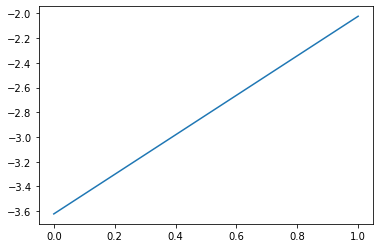

In [ ]:
# print(x_train_training[0][0].shape)
# print(x_train_training[0][0])
plt.plot(x_train_training[0][0])
plt.show()

In [ ]:
# train and test ResNet for recognizing WiFi signal

NUM_EPOCHS = 100
TRAIN_BATCH_SIZE = 256
VAL_BATCH_SIZE = 4096
LR = 1e-4

best_val_accuracy = 0
best_val_loss = 100
number_epoch_until_best = 1
training_time = 0
training_time_until_best = 0
average_time_per_epoch = 0

train_dataloader = data.DataLoader(
    dataset=data.TensorDataset(x_train_training, y_train_training), 
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)

test_dataloader = data.DataLoader(
    data.TensorDataset(x_test_training, y_test_training), 
    batch_size=VAL_BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)

model = LSTM()
model.cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

ash_var = True

for epoch_idx in range(1, NUM_EPOCHS+1):
    progress_training_epoch = tqdm(
        IteratorTimer(train_dataloader), 
        desc=f'Epoch {epoch_idx}/{NUM_EPOCHS}, Training',
        miniters=1, ncols=88, position=0,
        leave=True, total=len(train_dataloader), smoothing=.9)
    progress_validation_epoch = tqdm(
        IteratorTimer(test_dataloader), 
        desc=f'Epoch {epoch_idx}/{NUM_EPOCHS}, Validation',
        miniters=1, ncols=88, position=0, 
        leave=True, total=len(test_dataloader), smoothing=.9)
    
    model.train()
    train_loss = 0
    start_time = time.time()
    for batch_idx, (input, target) in enumerate(progress_training_epoch):
        batch_size = input.size()[0]
        input = input.cuda()
        target = target.cuda()
        if ash_var:
          print(input.shape)
          ash_var = False
        target_onehot = torch.zeros((batch_size, 15), dtype=torch.float).cuda().scatter_(
            dim=1, index=target.view(batch_size, 1), value=1.0)
        output = model(input)
        batch_loss = criterion(output, target_onehot)
        batch_loss.backward()
        optimizer.step()
        model.zero_grad()
        train_loss += batch_size * batch_loss
    training_time += time.time() - start_time
       
    model.eval()
    val_loss = 0
    test_total_num_correct = 0
    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(progress_validation_epoch):
            batch_size = input.size()[0]
            input = input.cuda()
            target = target.cuda()
            target_onehot = torch.zeros((batch_size, 15), dtype=torch.float).cuda().scatter_(
                dim=1, index=target.view(batch_size, 1), value=1.0)
            output = model(input)
            batch_loss = criterion(output, target_onehot)  
            val_loss += batch_size * batch_loss
            test_total_num_correct += torch.eq(output.argmax(dim=1), target).sum()  

    val_accuracy = test_total_num_correct.item()/(15*21*235)
    val_loss = val_loss/(15*21*235)
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        number_epoch_until_best_accuracy = epoch_idx
        training_time_until_best = training_time
        torch.save(model.state_dict(), 'drive/MyDrive/GradSchool/Capstone/Wireless Interference Identification Dataset/models/lstm_iq.pth')
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        number_epoch_until_best_loss = epoch_idx
        
    print(f'epoch:{epoch_idx}, '
          f'training loss:{(train_loss/(15*21*480)): .5f}, '
          f'validation loss:{val_loss: .5f}, '
          f'accuracy: {val_accuracy: .4f}, '
          f'best accuracy: {best_val_accuracy: .4f}')

    if epoch_idx > number_epoch_until_best_accuracy+4 and epoch_idx > number_epoch_until_best_loss+4:
        break

model.load_state_dict(torch.load('drive/MyDrive/GradSchool/Capstone/Wireless Interference Identification Dataset/models/lstm_iq.pth'))
model.cuda()
model.eval()

print(f'total training time: {training_time_until_best}')
print(f'number of epochs: {number_epoch_until_best_accuracy}')
print(f'time per epoch: {(training_time_until_best/number_epoch_until_best_accuracy): .2f}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch 1/100, Validation:   0%|                                   | 0/19 [01:41<?, ?it/s]


torch.Size([256, 128, 2])


Epoch 1/100, Validation: 100%|██████████████████████████| 19/19 [01:53<00:00,  5.96s/it]


epoch:1, training loss: 0.21280, validation loss: 0.16616, accuracy:  0.3904, best accuracy:  0.3904


Epoch 2/100, Validation: 100%|██████████████████████████| 19/19 [01:55<00:00,  6.06s/it]

epoch:2, training loss: 0.13439, validation loss: 0.11832, accuracy:  0.5725, best accuracy:  0.5725



Epoch 3/100, Validation: 100%|██████████████████████████| 19/19 [01:54<00:00,  6.02s/it]

epoch:3, training loss: 0.10431, validation loss: 0.09530, accuracy:  0.6706, best accuracy:  0.6706



Epoch 4/100, Validation: 100%|██████████████████████████| 19/19 [01:54<00:00,  6.02s/it]

epoch:4, training loss: 0.09168, validation loss: 0.08701, accuracy:  0.6864, best accuracy:  0.6864



Epoch 5/100, Validation: 100%|██████████████████████████| 19/19 [01:54<00:00,  6.04s/it]

epoch:5, training loss: 0.08180, validation loss: 0.08097, accuracy:  0.7206, best accuracy:  0.7206



Epoch 6/100, Validation: 100%|██████████████████████████| 19/19 [01:54<00:00,  6.01s/it]

epoch:6, training loss: 0.07560, validation loss: 0.07360, accuracy:  0.7379, best accuracy:  0.7379



Epoch 7/100, Validation: 100%|██████████████████████████| 19/19 [01:54<00:00,  6.03s/it]

epoch:7, training loss: 0.07071, validation loss: 0.06790, accuracy:  0.7685, best accuracy:  0.7685



Epoch 8/100, Validation: 100%|██████████████████████████| 19/19 [01:54<00:00,  6.03s/it]

epoch:8, training loss: 0.06564, validation loss: 0.06398, accuracy:  0.7844, best accuracy:  0.7844



Epoch 9/100, Validation: 100%|██████████████████████████| 19/19 [01:54<00:00,  6.03s/it]

epoch:9, training loss: 0.06272, validation loss: 0.06257, accuracy:  0.7859, best accuracy:  0.7859



Epoch 10/100, Validation: 100%|█████████████████████████| 19/19 [01:54<00:00,  6.03s/it]

epoch:10, training loss: 0.05928, validation loss: 0.06093, accuracy:  0.7871, best accuracy:  0.7871



Epoch 11/100, Validation: 100%|█████████████████████████| 19/19 [01:53<00:00,  5.99s/it]

epoch:11, training loss: 0.05636, validation loss: 0.05775, accuracy:  0.8044, best accuracy:  0.8044



Epoch 12/100, Validation: 100%|█████████████████████████| 19/19 [01:55<00:00,  6.06s/it]

epoch:12, training loss: 0.05450, validation loss: 0.05501, accuracy:  0.8119, best accuracy:  0.8119



Epoch 13/100, Validation: 100%|█████████████████████████| 19/19 [01:55<00:00,  6.06s/it]

epoch:13, training loss: 0.05294, validation loss: 0.05282, accuracy:  0.8224, best accuracy:  0.8224



Epoch 14/100, Validation: 100%|█████████████████████████| 19/19 [01:54<00:00,  6.03s/it]

epoch:14, training loss: 0.05127, validation loss: 0.05148, accuracy:  0.8277, best accuracy:  0.8277



Epoch 15/100, Validation: 100%|█████████████████████████| 19/19 [01:53<00:00,  5.98s/it]

epoch:15, training loss: 0.05020, validation loss: 0.04970, accuracy:  0.8351, best accuracy:  0.8351



Epoch 16/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.93s/it]

epoch:16, training loss: 0.04880, validation loss: 0.04953, accuracy:  0.8356, best accuracy:  0.8356



Epoch 17/100, Validation: 100%|█████████████████████████| 19/19 [01:53<00:00,  5.95s/it]

epoch:17, training loss: 0.04761, validation loss: 0.04857, accuracy:  0.8392, best accuracy:  0.8392



Epoch 18/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.92s/it]

epoch:18, training loss: 0.04616, validation loss: 0.04627, accuracy:  0.8482, best accuracy:  0.8482



Epoch 19/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.90s/it]

epoch:19, training loss: 0.04489, validation loss: 0.04648, accuracy:  0.8470, best accuracy:  0.8482



Epoch 20/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.94s/it]

epoch:20, training loss: 0.04379, validation loss: 0.04437, accuracy:  0.8546, best accuracy:  0.8546



Epoch 21/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.91s/it]

epoch:21, training loss: 0.04293, validation loss: 0.04302, accuracy:  0.8571, best accuracy:  0.8571



Epoch 22/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.93s/it]

epoch:22, training loss: 0.04231, validation loss: 0.04515, accuracy:  0.8518, best accuracy:  0.8571



Epoch 23/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.93s/it]

epoch:23, training loss: 0.04205, validation loss: 0.04370, accuracy:  0.8568, best accuracy:  0.8571



Epoch 24/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.94s/it]

epoch:24, training loss: 0.04116, validation loss: 0.04251, accuracy:  0.8592, best accuracy:  0.8592



Epoch 25/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.94s/it]

epoch:25, training loss: 0.04075, validation loss: 0.04207, accuracy:  0.8595, best accuracy:  0.8595



Epoch 26/100, Validation: 100%|█████████████████████████| 19/19 [01:51<00:00,  5.89s/it]

epoch:26, training loss: 0.04042, validation loss: 0.04205, accuracy:  0.8596, best accuracy:  0.8596



Epoch 27/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.92s/it]

epoch:27, training loss: 0.04077, validation loss: 0.04349, accuracy:  0.8588, best accuracy:  0.8596



Epoch 28/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.95s/it]

epoch:28, training loss: 0.04036, validation loss: 0.04237, accuracy:  0.8605, best accuracy:  0.8605



Epoch 29/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.92s/it]

epoch:29, training loss: 0.03957, validation loss: 0.04119, accuracy:  0.8651, best accuracy:  0.8651



Epoch 30/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.93s/it]

epoch:30, training loss: 0.03909, validation loss: 0.04161, accuracy:  0.8627, best accuracy:  0.8651



Epoch 31/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.90s/it]

epoch:31, training loss: 0.03868, validation loss: 0.04135, accuracy:  0.8632, best accuracy:  0.8651



Epoch 32/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.94s/it]

epoch:32, training loss: 0.03843, validation loss: 0.04183, accuracy:  0.8625, best accuracy:  0.8651



Epoch 33/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.94s/it]

epoch:33, training loss: 0.03825, validation loss: 0.04090, accuracy:  0.8645, best accuracy:  0.8651



Epoch 34/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.93s/it]

epoch:34, training loss: 0.03781, validation loss: 0.04025, accuracy:  0.8680, best accuracy:  0.8680



Epoch 35/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.91s/it]

epoch:35, training loss: 0.03747, validation loss: 0.04129, accuracy:  0.8638, best accuracy:  0.8680



Epoch 36/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.91s/it]

epoch:36, training loss: 0.03726, validation loss: 0.04076, accuracy:  0.8653, best accuracy:  0.8680



Epoch 37/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.95s/it]

epoch:37, training loss: 0.03713, validation loss: 0.04035, accuracy:  0.8669, best accuracy:  0.8680



Epoch 38/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.93s/it]

epoch:38, training loss: 0.03684, validation loss: 0.04082, accuracy:  0.8646, best accuracy:  0.8680



Epoch 39/100, Validation: 100%|█████████████████████████| 19/19 [01:52<00:00,  5.91s/it]

epoch:39, training loss: 0.03642, validation loss: 0.04032, accuracy:  0.8670, best accuracy:  0.8680
total training time: 3472.6479489803314
number of epochs: 34
time per epoch:  102.14


In [ ]:
accuracy_each_class = np.zeros(15)

model.eval()
with torch.no_grad():
    for i in range(15):
        target = y_test_plot[i].contiguous().view(21*235)
        input = x_test_plot[i].cuda().contiguous().view(21*235, 128, 2)
        output = model(input).argmax(dim=1).cpu()
        num_correct = torch.eq(output, target).sum().item()
        accuracy_each_class[i] = num_correct / (21 * 235)

print(accuracy_each_class[:10].mean())
print(accuracy_each_class[10:13].mean())
print(accuracy_each_class[13:].mean())

0.9088145896656534
0.7338061465721041
0.8648429584599797


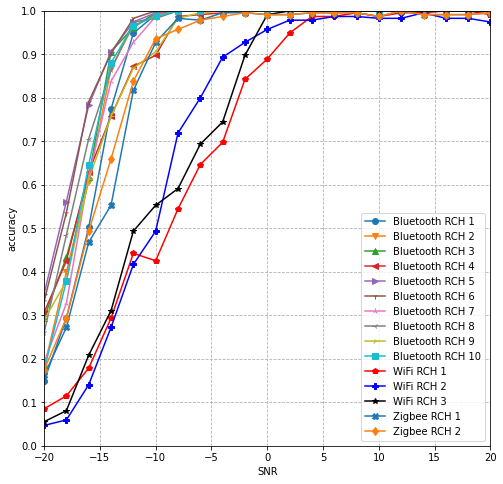

In [ ]:
# plot accuracy vs SNR for each class
accuracy_each_class_each_SNR = np.zeros((15, 21))

plt.figure(figsize=(8, 8))
plt.xlim([-20, 20])
plt.ylim([0, 1])
plt.yticks(np.linspace(0, 1, 11))
plt.xlabel('SNR')
plt.ylabel('accuracy')
plt.grid(linestyle='--')

model.eval()
with torch.no_grad():
    for i in range(15):
        for j in range(21):
            target = y_test_plot[i, j]
            input = x_test_plot[i, j].cuda()
            output = model(input).argmax(dim=1).cpu()
            num_correct = torch.eq(output, target).sum().item()
            accuracy_each_class_each_SNR[i, j] = num_correct / 235

plt.plot(
    range(-20, 21, 2), accuracy_each_class_each_SNR[0], 
    label='Bluetooth RCH 1', marker='o')
plt.plot(
    range(-20, 21, 2), accuracy_each_class_each_SNR[1], 
    label='Bluetooth RCH 2', marker='v')
plt.plot(
    range(-20, 21, 2), accuracy_each_class_each_SNR[2], 
    label='Bluetooth RCH 3', marker='^')
plt.plot(
    range(-20, 21, 2), accuracy_each_class_each_SNR[3], 
    label='Bluetooth RCH 4', marker='<')
plt.plot(
    range(-20, 21, 2), accuracy_each_class_each_SNR[4], 
    label='Bluetooth RCH 5', marker='>')
plt.plot(
    range(-20, 21, 2), accuracy_each_class_each_SNR[5], 
    label='Bluetooth RCH 6', marker='1')
plt.plot(
    range(-20, 21, 2), accuracy_each_class_each_SNR[6], 
    label='Bluetooth RCH 7', marker='2')
plt.plot(
    range(-20, 21, 2), accuracy_each_class_each_SNR[7], 
    label='Bluetooth RCH 8', marker='3')
plt.plot(
    range(-20, 21, 2), accuracy_each_class_each_SNR[8], 
    label='Bluetooth RCH 9', marker='4')
plt.plot(
    range(-20, 21, 2), accuracy_each_class_each_SNR[9], 
    label='Bluetooth RCH 10', marker='s')
plt.plot(
    range(-20, 21, 2), accuracy_each_class_each_SNR[10], 
    label='WiFi RCH 1', marker='p', color='red')
plt.plot(
    range(-20, 21, 2), accuracy_each_class_each_SNR[11], 
    label='WiFi RCH 2', marker='P', color='blue')
plt.plot(
    range(-20, 21, 2), accuracy_each_class_each_SNR[12], 
    label='WiFi RCH 3', marker='*', color='black')
plt.plot(
    range(-20, 21, 2), accuracy_each_class_each_SNR[13], 
    label='Zigbee RCH 1', marker='X')
plt.plot(
    range(-20, 21, 2), accuracy_each_class_each_SNR[14], 
    label='Zigbee RCH 2', marker='d')

plt.legend(loc='lower right')
plt.savefig("cnn-line-each-SNR")
plt.show()

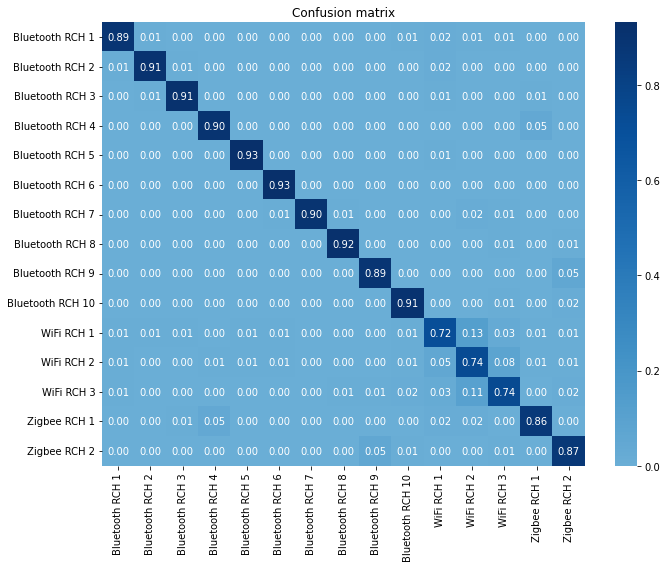

In [ ]:
# plot confusion matrix for all SNR
classes = ['Bluetooth RCH 1',
           'Bluetooth RCH 2',
           'Bluetooth RCH 3',
           'Bluetooth RCH 4',
           'Bluetooth RCH 5',
           'Bluetooth RCH 6',
           'Bluetooth RCH 7',
           'Bluetooth RCH 8',
           'Bluetooth RCH 9',
           'Bluetooth RCH 10',
           'WiFi RCH 1',
           'WiFi RCH 2',
           'WiFi RCH 3',
           'Zigbee RCH 1',
           'Zigbee RCH 2']
confusion_matrix = np.zeros((15, 15))
confusion_matrix_norm = np.zeros((15, 15))

model.eval()
with torch.no_grad():
    for i in range(15):
        input = x_test_confusion[i].cuda()
        output= model(input).argmax(dim=1).cpu()
        confusion_matrix[i] = output.bincount()
    
confusion_matrix_norm = confusion_matrix / (21*235)
confusion_matrix_norm = (confusion_matrix_norm > 0.01) * confusion_matrix_norm

plot_confusion_matrix(confusion_matrix_norm, labels=classes)
plt.tight_layout()
plt.savefig("cnn-confusion-all")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


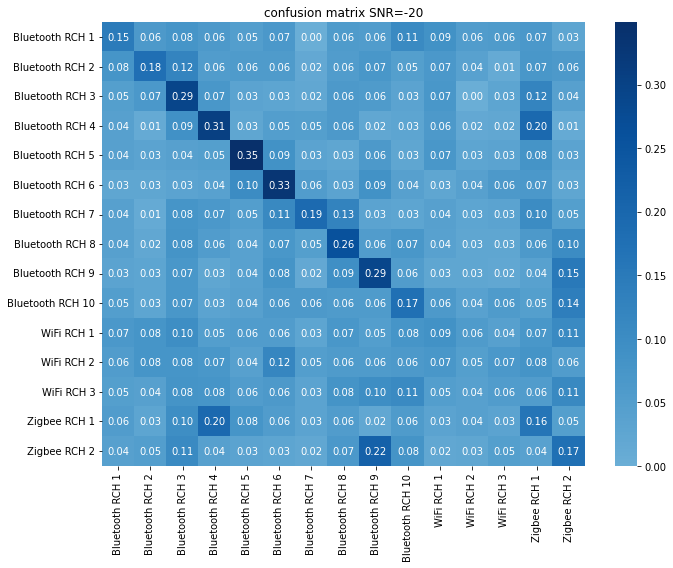

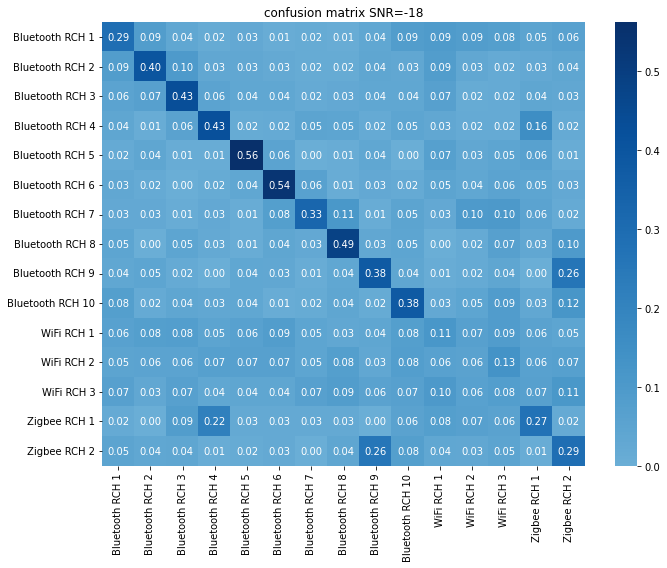

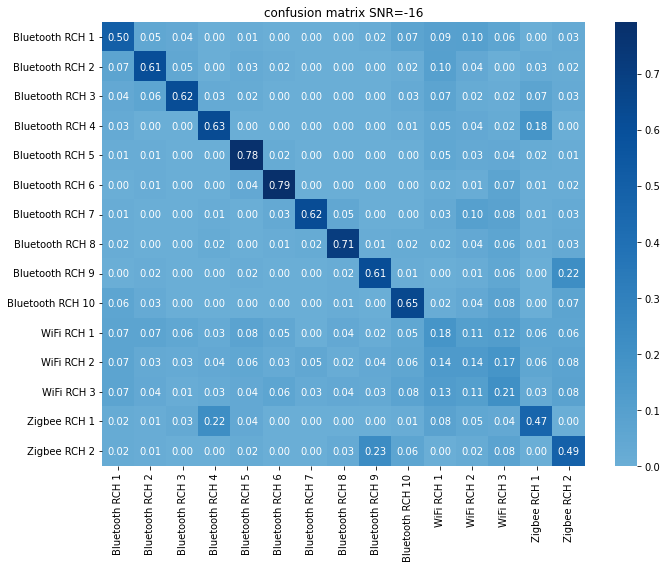

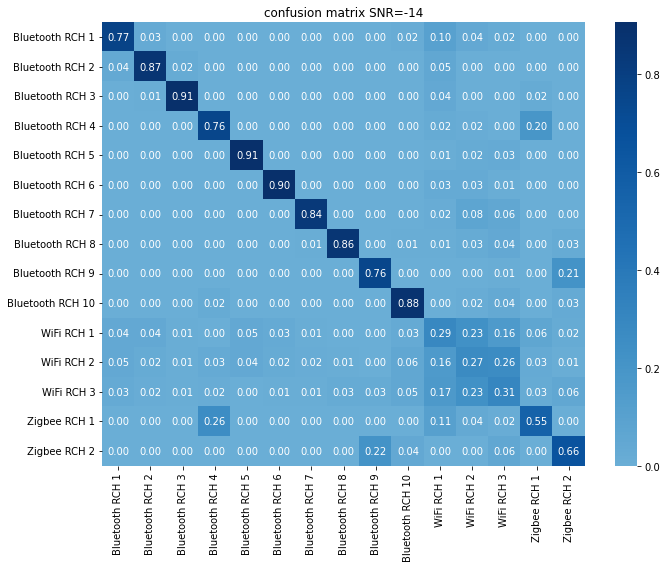

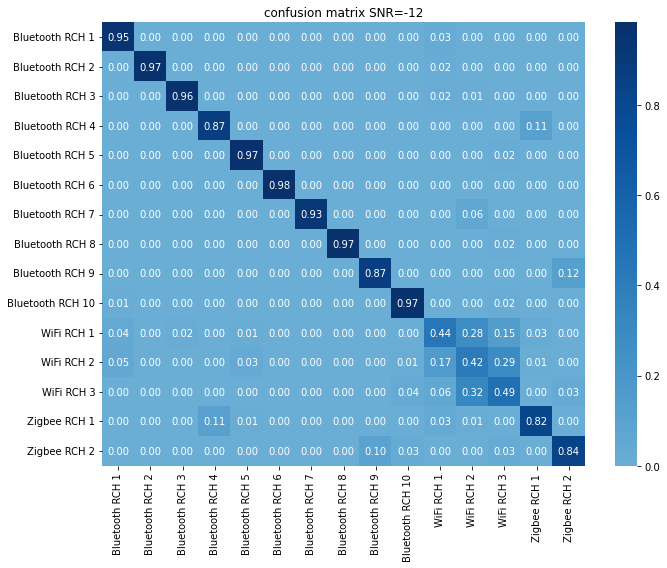

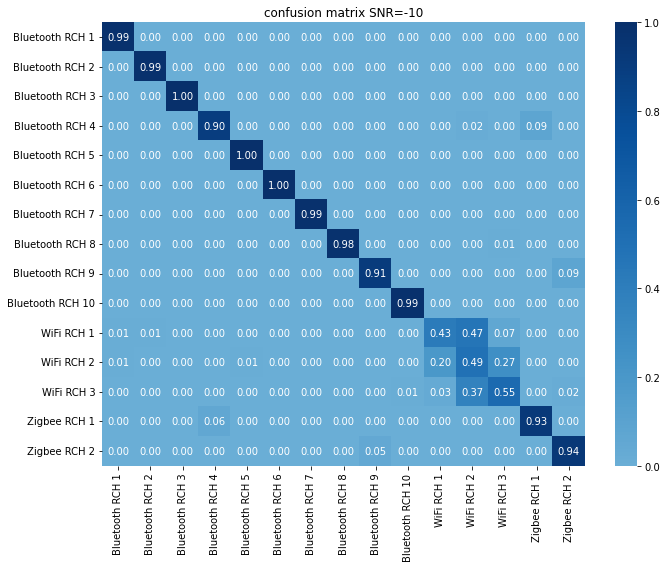

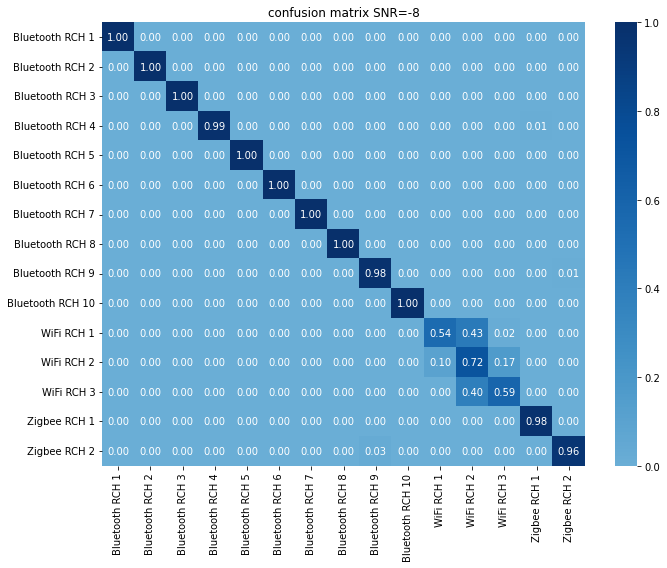

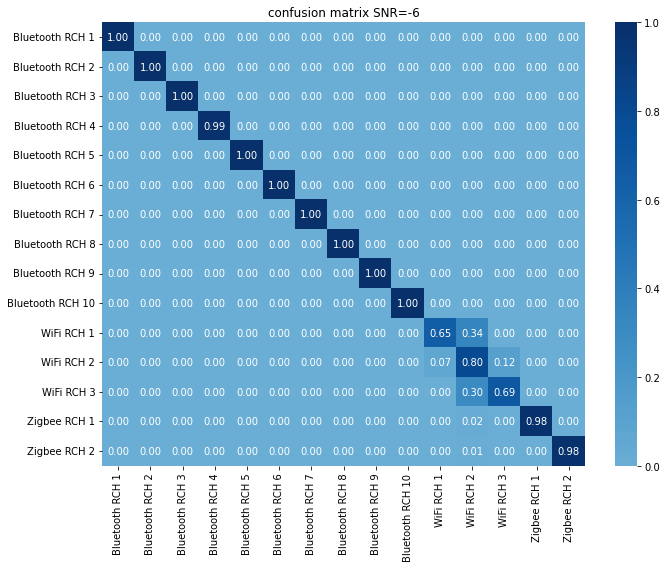

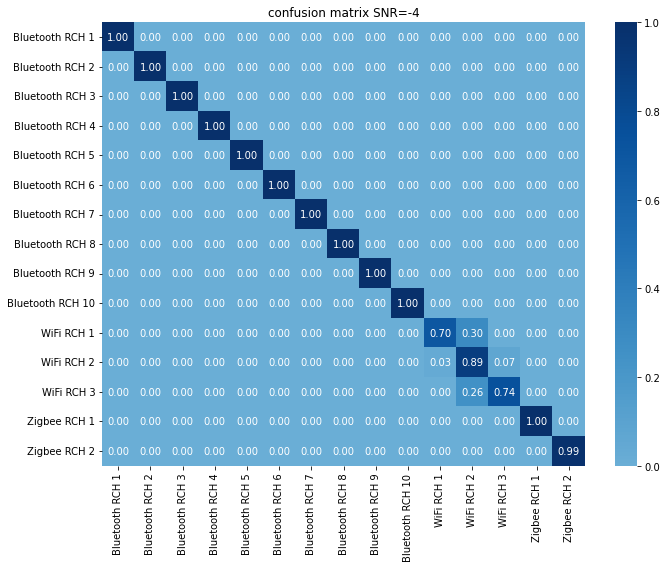

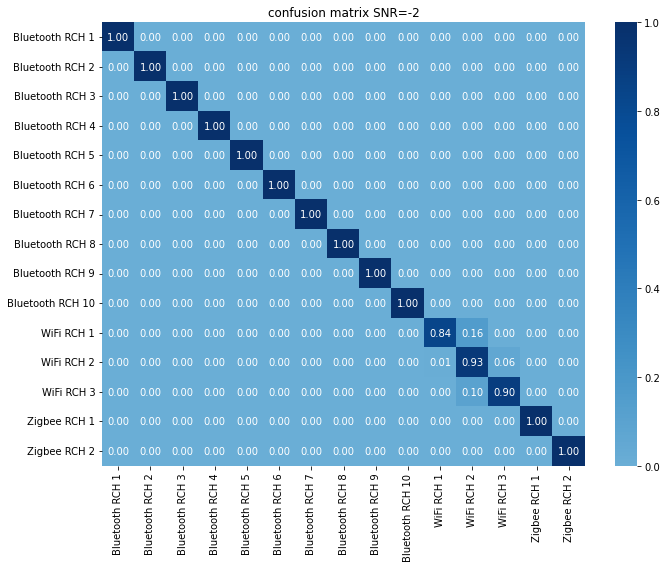

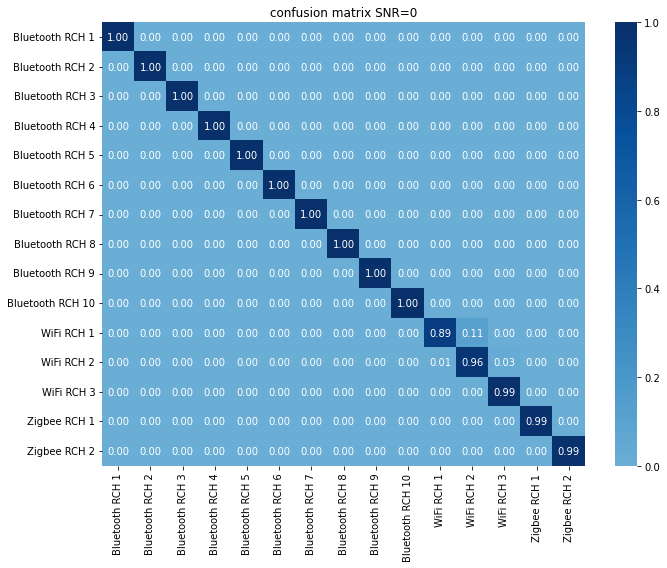

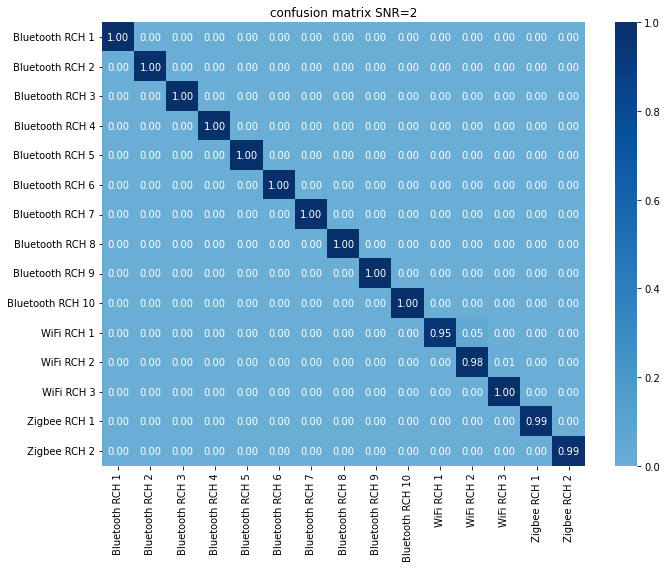

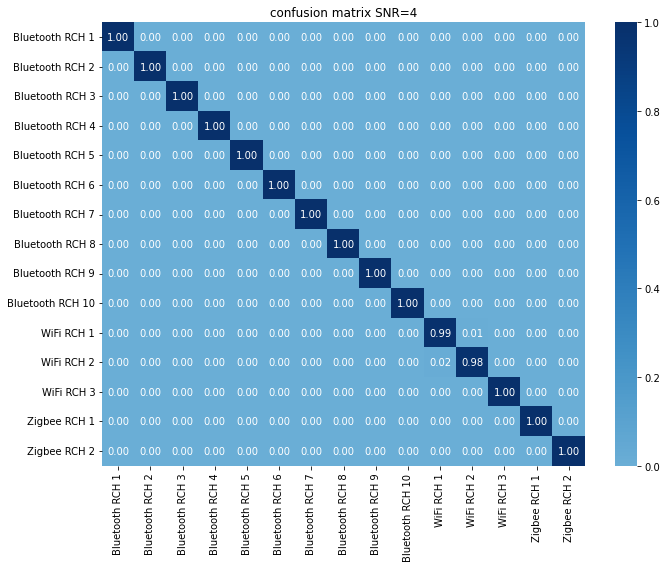

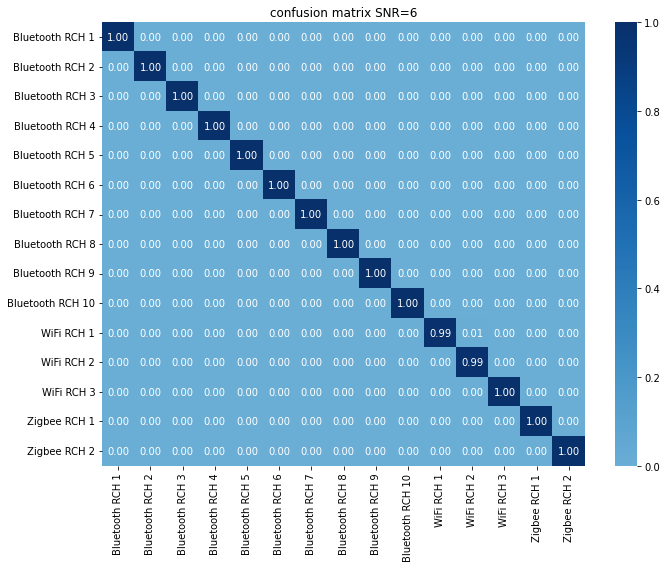

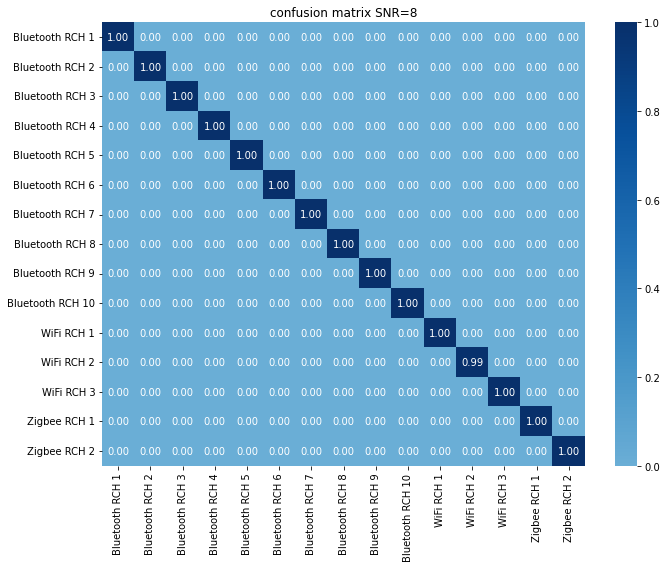

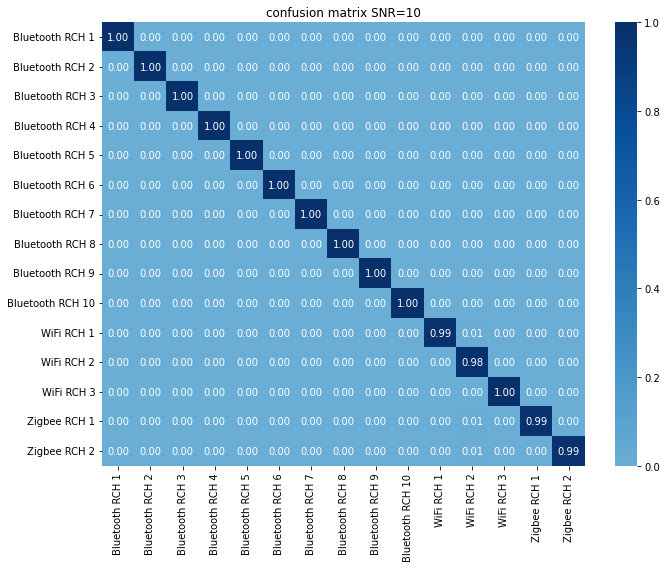

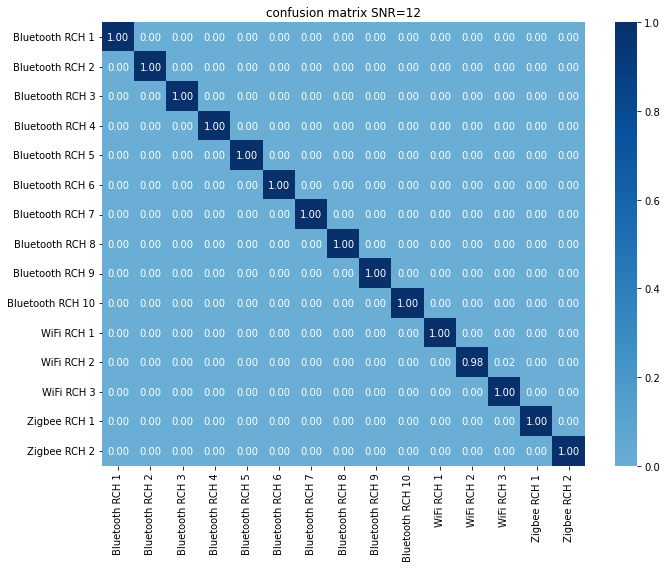

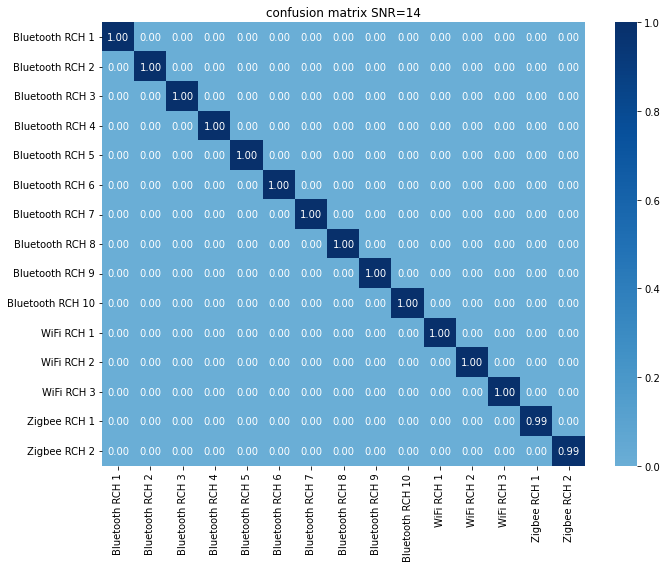

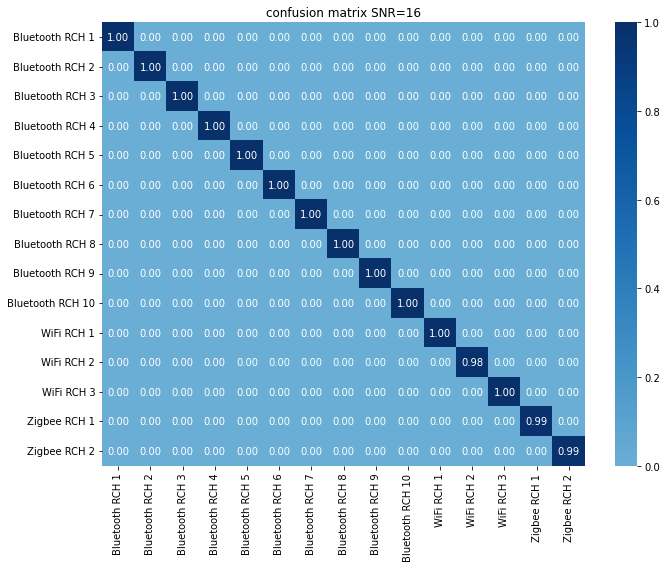

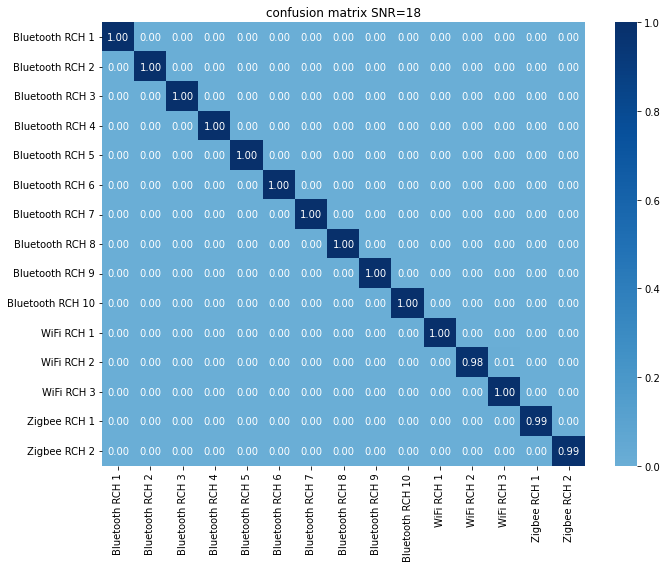

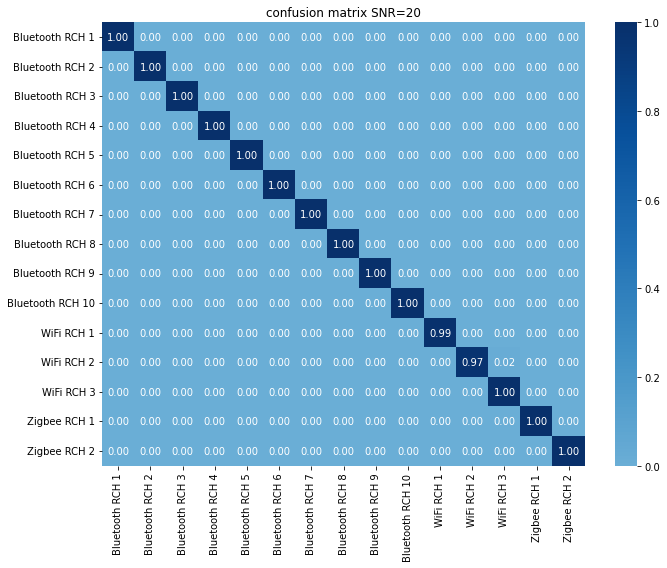

In [ ]:
classes = ['Bluetooth RCH 1',
           'Bluetooth RCH 2',
           'Bluetooth RCH 3',
           'Bluetooth RCH 4',
           'Bluetooth RCH 5',
           'Bluetooth RCH 6',
           'Bluetooth RCH 7',
           'Bluetooth RCH 8',
           'Bluetooth RCH 9',
           'Bluetooth RCH 10',
           'WiFi RCH 1',
           'WiFi RCH 2',
           'WiFi RCH 3',
           'Zigbee RCH 1',
           'Zigbee RCH 2']
confusion_matrix = np.zeros((15, 15))
confusion_matrix_norm = np.zeros((15, 15))

model.eval()
with torch.no_grad():
    for j in range(21):
        confusion_matrix = np.zeros((15, 15))
        for i in range(15):
            input = x_test_confusion_each_SNR[j, i].cuda()
            output= model(input).argmax(dim=1).cpu()
            confusion_matrix[i] = output.bincount(minlength=15)
        confusion_matrix_norm = confusion_matrix / 235
        confusion_matrix_norm = (confusion_matrix_norm > 0.01) * confusion_matrix_norm
        
        plot_confusion_matrix(confusion_matrix_norm, 
                              title=f'confusion matrix SNR={-20 + j*2}', 
                              labels=classes)
        plt.tight_layout()

        plt.savefig(f"cnn-confusion-SNR{-20 + j*2}")

In [ ]:
model.eval() 

# Let's create a dummy input tensor  
dummy_input = torch.randn(1 ,128,2, requires_grad=True)  
dummy_input = dummy_input.cuda()
# Export the model   
torch.onnx.export(model,         # model being run 
      dummy_input,       # model input (or a tuple for multiple inputs) 
      "drive/MyDrive/GradSchool/Capstone/Wireless Interference Identification Dataset/models/lstm_iq.onnx",       # where to save the model  
      export_params=True,  # store the trained parameter weights inside the model file 
      opset_version=10,    # the ONNX version to export the model to 
      do_constant_folding=True,  # whether to execute constant folding for optimization 
      input_names = ['modelInput'],   # the model's input names 
      output_names = ['modelOutput'], # the model's output names 
      )

# torch.onnx.export(model,
#                   dummy_input,
#                   "drive/MyDrive/GradSchool/Capstone/Wireless Interference Identification Dataset/models/fft_smaller_cnn_model.onnx",
#                   export_params=True,
#                   opset_version=10,
#                   do_constant_folding=True,
#                   input_names = ['modelInput'],
#                   output_names = ['modelOutput'],
#                   dynamic_axes={'modelInput' : {0 : 'batch_size'}, 'modelOutput' : {0 : 'batch_size'}})
print(" ") 
print('Model has been converted to ONNX')

 
Model has been converted to ONNX


/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:2123: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  "or define the initial states (h0/c0) as inputs of the model. ")
